<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### Load Data From CSV File


In [2]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


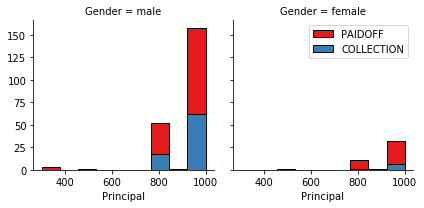

In [6]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

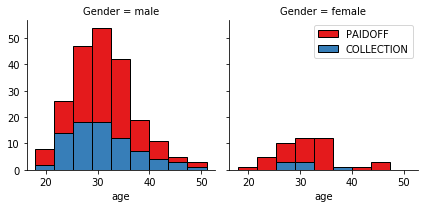

In [7]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


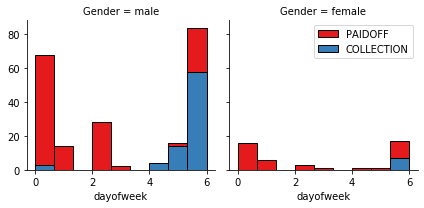

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
#Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [22]:
#Split data set into train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [23]:
#Determine K value through Accuracy Evaluation:
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

In [26]:
#quick check that predicted values are as expected (either PAIDOFF or COLLECTION):
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

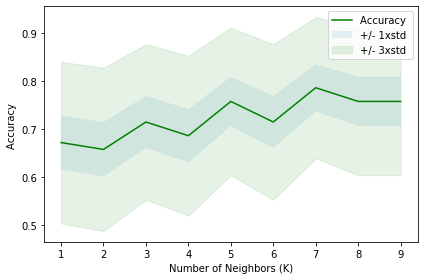

The best accuracy was with 0.7857142857142857 with k= 7


In [27]:
# Plot the model accuracy for a different number of neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [28]:
#Build the model this time using the k value that produced the highest accuracy 
knn = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1)
#Fit the model with the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [29]:
#Make some predictions
knn_yhat = knn.predict(X_test)

# Decision Tree

In [ ]:
#Comment these out when installed
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [30]:
#Import Libraries
from sklearn.tree import DecisionTreeClassifier
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

In [31]:
#We must find the optimum depth to choose:
ds = 10
mean_acc = np.zeros((ds-1))
std_acc = np.zeros((ds-1))

for d in range(1,ds):
    
    #Train Model and Predict  
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = d).fit(X_train, y_train)
    
    #Predict the response for the test dataset
    yhat=dt.predict(X_test)
    
    #Calculate the accuracy score
    mean_acc[d-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[d-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    print("For depth = {}  the accuracy score is {} ".format(d, mean_acc[d-1]))


For depth = 1  the accuracy score is 0.7857142857142857 
For depth = 2  the accuracy score is 0.7857142857142857 
For depth = 3  the accuracy score is 0.6142857142857143 
For depth = 4  the accuracy score is 0.6142857142857143 
For depth = 5  the accuracy score is 0.6428571428571429 
For depth = 6  the accuracy score is 0.7714285714285715 
For depth = 7  the accuracy score is 0.7571428571428571 
For depth = 8  the accuracy score is 0.7571428571428571 
For depth = 9  the accuracy score is 0.6571428571428571 


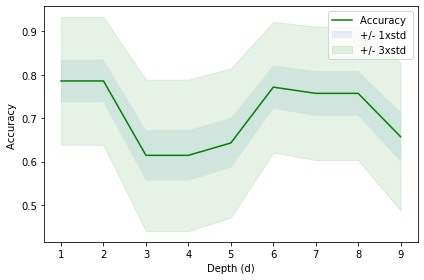

The best accuracy was with 0.7857142857142857 with d= 2


In [32]:
# Plot the model accuracy for different depths
plt.plot(range(1,ds),mean_acc,'g')
plt.fill_between(range(1,ds),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,ds),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth (d)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with d=", mean_acc.argmax()+2) #best is with d=1, but use 2 so +2 instead of +1 in print statement

In [33]:
#The greatest accuracy was with depth = 1, but depth = 2 makes more sense to use here as it was also equal

In [34]:
#Build the model this time using the d value that produced the highest accuracy 
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=2)

#fit the data with the training set
loanTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [35]:
#make some predictions:
predTree = loanTree.predict(X_test)

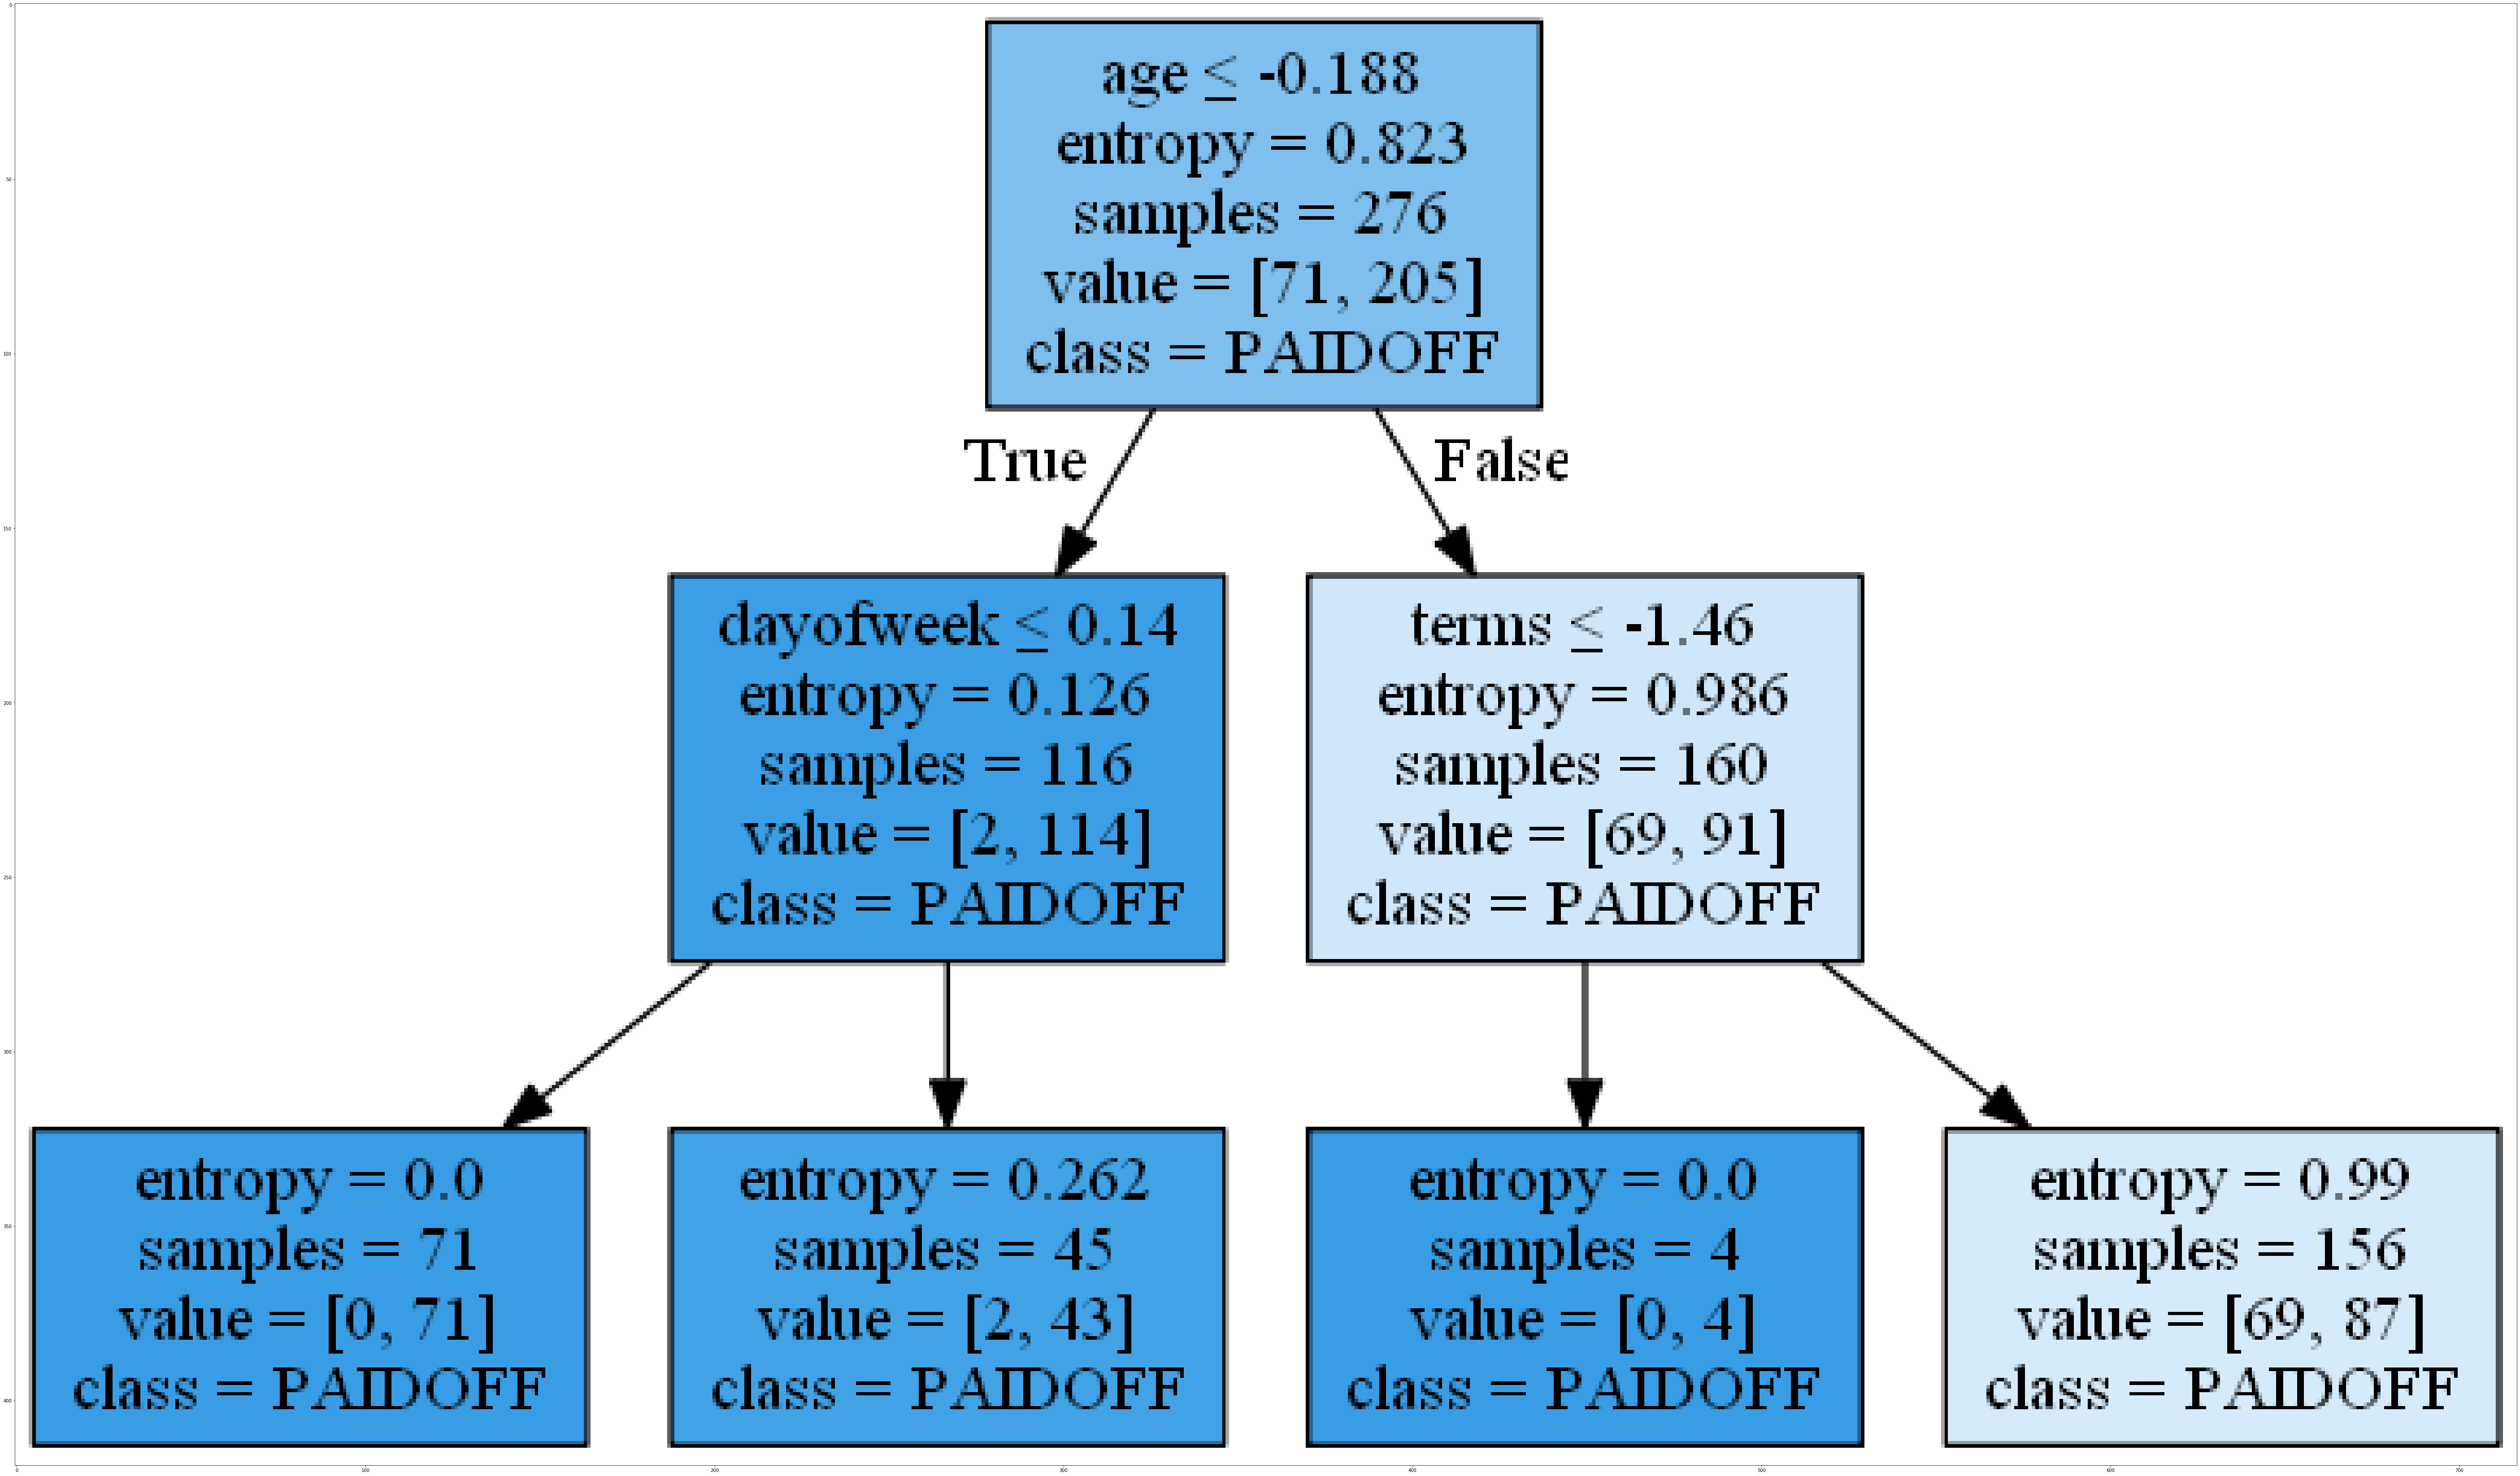

In [36]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = df.columns[3:11]
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [37]:
#Import Libraries
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Use the Radial Basis Function (the default)
svm_model = svm.SVC(kernel='rbf')
#Fit the model with the training set
svm_model.fit(X_train, y_train) 

SVC()

In [38]:
#Make some predictions
yhat = svm_model.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Logistic Regression


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [40]:
#choose which function to use
for k in ('lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag'):
    LR_model = LogisticRegression(C = 0.01, solver = k).fit(X_train, y_train)
    LR_yhat = LR_model.predict(X_test)
    y_prob = LR_model.predict_proba(X_test)
    print('Solver: {}, logloss: {}'.format(k, log_loss(y_test, y_prob)))

Solver: lbfgs, logloss: 0.4920179847937498
Solver: saga, logloss: 0.49201948568367027
Solver: liblinear, logloss: 0.5772287609479654
Solver: newton-cg, logloss: 0.492017801467927
Solver: sag, logloss: 0.4920289144344473


In [41]:
#logloss is highest when solver is liblinear

In [42]:
#Train and fit the model with the training set
LR_model = LogisticRegression(solver = 'liblinear', C=0.01).fit(X_train,y_train)
LR_model

LogisticRegression(C=0.01, solver='liblinear')

In [43]:
#Make some predictions
yhat = LR_model.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Model Evaluation using Test set


In [44]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


### Load Test set for evaluation


In [45]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [46]:
#convert date types to date time objects
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

#set a threshold less than day 4
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#Convert Categorical features to numerical values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#one hot encoding for education 
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Testing feature
X_loan_test = test_feature

# Normalizing Test Data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)

# Target result
y_loan_test = test_df['loan_status'].values

In [47]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [49]:
#METRICS

# KNN
knn_yhat = knn.predict(X_loan_test)
#Jaccard Score:
knn_js = round(jaccard_score(y_loan_test, knn_yhat, pos_label = "PAIDOFF"), 2)
#F1 Score:
knn_f1 = round(f1_score(y_loan_test, knn_yhat, average = 'weighted'), 2)

# Decision Tree
loanTree_yhat = loanTree.predict(X_loan_test)
#Jaccard Score:
loanTree_js = round(jaccard_score(y_loan_test, loanTree_yhat, pos_label = "PAIDOFF"), 2)
#F1 Score:
loanTree_f1 = round(f1_score(y_loan_test, loanTree_yhat, average = 'weighted'), 2)

# Support Vector Machine
svm_model_yhat = svm_model.predict(X_loan_test)
#Jaccard Score:
svm_model_js = round(jaccard_score(y_loan_test, svm_model_yhat, pos_label = "PAIDOFF"), 2)
#F1 Score:
svm_model_f1 = round(f1_score(y_loan_test, svm_model_yhat, average = 'weighted'), 2)

# Logistic Regression
LR_model_yhat = LR_model.predict(X_loan_test)
#Jaccard Score:
LR_model_js = round(jaccard_score(y_loan_test, LR_model_yhat, pos_label = "PAIDOFF"), 2)
#F1 Score:
LR_model_f1 = round(f1_score(y_loan_test, LR_model_yhat, average = 'weighted'), 2)
#LogLoss:
LR_model_logloss = round(log_loss(y_test, LR_model.predict_proba(X_test)),2)

In [50]:
Jaccard_scores = [knn_js, loanTree_js, svm_model_js, LR_model_js]
F1_scores = [knn_f1, loanTree_f1, svm_model_f1, LR_model_f1]
LogLoss_scores = ['NA', 'NA', 'NA', LR_model_logloss]


all_values = [Jaccard_scores, F1_scores, LogLoss_scores]

In [51]:
algorithms = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
metrics = ['Jaccard', 'F1-score', 'Logloss']

accuracy_df = pd.DataFrame(all_values, index = metrics, columns = algorithms)
accuracy_df.transpose()

,Jaccard,F1-score,Logloss
KNN,0.65,0.63,NA
Decision Tree,0.74,0.63,NA
SVM,0.78,0.76,NA
Logistic Regression,0.74,0.66,0.58
